# Imports

In [2]:
import pandas as pd
import numpy as np
import shutil
import os
import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import preprocessing
from scipy.io import wavfile

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
dist = tfp.distributions
BASE_PATH = "YOUR/BASE/PATH"

In [3]:
#df_downsampled.to_csv("balanced.csv")
datapath = "balanced.csv"

## Results

In [8]:
X, y = load_data()
data_main = split_data(X, y, test_size=0.1, valid_size=0.1)

X, y = load_data_mf()
data_gender = split_data(X, y, test_size=0.1, valid_size=0.1)

bnn_main = tf.keras.models.load_model("voice_results/voice_bnn_model_1")
nn_main = tf.keras.models.load_model("voice_results/voice_nn_model_3")
bnn_gender = tf.keras.models.load_model("voice_results/voice_bnn_gender_model_1")
nn_gender = tf.keras.models.load_model("voice_results/voice_nn_gender_model_1")


In [61]:
print('Age Classes')

(unique, counts) = np.unique(data_main['y_test'], return_counts=True)

print(np.asarray((unique, counts)))

print('Gender Classes')

(unique, counts) = np.unique(data_gender['y_test'], return_counts=True)

print(np.asarray((unique, counts)))

Age Classes
[[0.000e+00 1.000e+00 2.000e+00 3.000e+00 4.000e+00 5.000e+00 6.000e+00
  7.000e+00 8.000e+00]
 [3.633e+03 5.180e+02 4.930e+02 1.300e+01 4.960e+02 4.620e+02 5.040e+02
  4.960e+02 5.060e+02]]
Gender Classes
[[0.000e+00 1.000e+00]
 [4.536e+03 2.585e+03]]


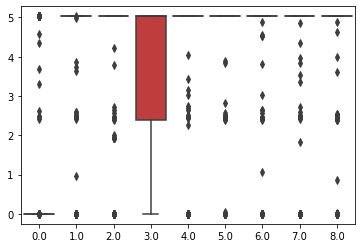

In [38]:
plot_predictions(nn_main, data_main)

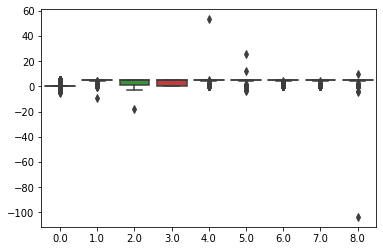

In [41]:
plot_predictions(bnn_main, data_main)

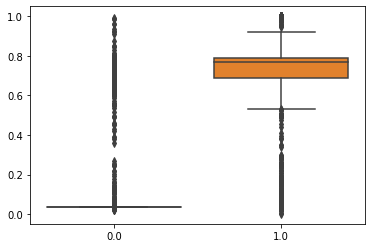

In [36]:
plot_predictions(nn_gender, data_gender)

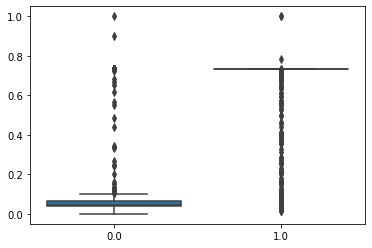

In [35]:
plot_predictions(bnn_gender, data_gender)


In [34]:
def plot_predictions(model, data):
    predictions = [item for sublist in model.predict(data['X_test']) for item in sublist]
    data['predictions'] = predictions
    sns.boxplot(x= [item for sublist in data['y_test'] for item in sublist], y=data["predictions"])

# Preprocessing: Read and clean the data

In [62]:
datapath = "validated.tsv"

df = pd.read_csv(datapath, sep='\t', header=0)
df = df.drop(columns=["client_id", "sentence", "up_votes", "down_votes", "accent", "segment", "locale"])

n_samples = len(df_all)
print("Total samples:", n_samples)

print(df_all['gender'].value_counts())


Total samples: 786372
male      584206
female    178911
other      23255
Name: gender, dtype: int64


In [36]:
df.head()

,path,age,gender
10,common_voice_en_18295850.mp3,twenties,male
42,common_voice_en_22338655.mp3,twenties,female
53,common_voice_en_18277778.mp3,fourties,male
59,common_voice_en_21943181.mp3,twenties,male
61,common_voice_en_20586574.mp3,twenties,male


In [13]:
# Separate majority and minority classes
df_teens = df[df.age=='teens']
df_twenties = df[df.age=='twenties']
df_thirties = df[df.age=='thirties']
df_fourties = df[df.age=='fourties']
df_fifties = df[df.age=='fifties']
df_sixties = df[df.age=='sixties']
df_seventies = df[df.age=='seventies']
df_eighties = df[df.age=='eighties']
df_nineties = df[df.age=='nineties']
 
# Downsample majority class
df_teens_downsampled = resample(df_teens, 
                                 replace=False,    # sample without replacement
                                 n_samples=5000,     # to match minority class
                                 random_state=123) # reproducible results

df_twenties_downsampled = resample(df_twenties, 
                                 replace=False,    # sample without replacement
                                 n_samples=5000,     # to match minority class
                                 random_state=123) # reproducible results

df_thirties_downsampled = resample(df_thirties, 
                                 replace=False,    # sample without replacement
                                 n_samples=5000,     # to match minority class
                                 random_state=123) # reproducible results

df_fourties_downsampled = resample(df_fourties, 
                                 replace=False,    # sample without replacement
                                 n_samples=5000,     # to match minority class
                                 random_state=123) # reproducible results

df_fifties_downsampled = resample(df_fifties, 
                                 replace=False,    # sample without replacement
                                 n_samples=5000,     # to match minority class
                                 random_state=123) # reproducible results

df_sixties_downsampled = resample(df_sixties, 
                                 replace=False,    # sample without replacement
                                 n_samples=5000,     # to match minority class
                                 random_state=123) # reproducible results                                 

df_seventies_downsampled = resample(df_seventies, 
                                 replace=False,    # sample without replacement
                                 n_samples=5000,     # to match minority class
                                 random_state=123) # reproducible results   


# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_teens_downsampled, df_twenties_downsampled, df_thirties_downsampled, df_fourties_downsampled, df_fifties_downsampled, df_sixties_downsampled,                                        df_seventies_downsampled, df_eighties, df_nineties])
 
# Display new class counts
df_downsampled.age.value_counts()

for i in df_downsampled.index:
    shutil.copy(f'{BASE_PATH}/Downloads/en.tar/en/cv-corpus-6.1-2020-12-11/en/clips/{df_downsampled.path[i]}', './clips')

# Define Helper Methods

In [4]:
def load_data(vector_length=15360):
    """A function to load gender recognition dataset from `data` folder
    After the second run, this will load from results/features.npy and results/labels.npy files
    as it is much faster!"""
    # make sure results folder exists
    if not os.path.isdir("cached"):
        os.mkdir("cached")
    # if features & labels already loaded individually and bundled, load them from there instead
    if os.path.isfile("cached/features.npy") and os.path.isfile("cached/labels.npy"):
        X = np.load("cached/features.npy")
        y = np.load("cached/labels.npy")
        return X, y
    # read dataframe
    df = pd.read_csv(datapath)
    #lables 2 int
    le = preprocessing.LabelEncoder()
    le.fit(df['age'])
    df['categorical_label'] = le.transform(df['age'])

    # get total samples
    n_samples = len(df)
    # initialize an empty array for all audio features
    X = np.zeros((n_samples, vector_length))
    # initialize an empty array for all audio labels //(1 for male and 0 for female)
    y = np.zeros((n_samples, 1))
    for i, (filename, age) in tqdm.tqdm(enumerate(zip(df['path'], df['categorical_label'])), "Loading data", total=n_samples):
        filepath = f'{BASE_PATH}/OneDrive/Documents/Uni/ppl/voice_project/wav_clips/{filename}'
        if not os.path.isfile(filepath):
            continue
        file = wavfile.read(filepath)
        l = min(vector_length, len(file[1]))
        X[i][:l] = file[1][:l]
        y[i] = age
    # save the audio features and labels into files
    # so we won't load each one of them next run
    np.save("cached/features", X)
    np.save("cached/labels", y)
    return X, y

In [5]:
def map_group(x):
    if x < 3:
        return 0
    if x < 6:
        return 1
    return 2

def load_data_3_groups(vector_length=15360):
    """A function to load gender recognition dataset from `data` folder
    After the second run, this will load from results/features.npy and results/labels.npy files
    as it is much faster!"""
    # make sure results folder exists
    if not os.path.isdir("cached"):
        os.mkdir("cached")
    # if features & labels already loaded individually and bundled, load them from there instead
    if os.path.isfile("cached/features.npy") and os.path.isfile("cached/labels.npy"):
        X = np.load("cached/features.npy")
        y = np.array([map_group(x) for x in np.load("cached/labels.npy")])
        return X, y
    # read dataframe
    df = pd.read_csv(datapath)
    #lables 2 int
    le = preprocessing.LabelEncoder()
    le.fit(df['age'])
    df['categorical_label'] = le.transform(df['age'])

    # get total samples
    n_samples = len(df)
    # initialize an empty array for all audio features
    X = np.zeros((n_samples, vector_length))
    # initialize an empty array for all audio labels //(1 for male and 0 for female)
    y = np.zeros((n_samples, 1))
    for i, (filename, age) in tqdm.tqdm(enumerate(zip(df['path'], df['categorical_label'])), "Loading data", total=n_samples):
        filepath = f'{BASE_PATH}/OneDrive/Documents/Uni/ppl/voice_project/wav_clips/{filename}'
        if not os.path.isfile(filepath):
            continue
        file = wavfile.read(filepath)
        l = min(vector_length, len(file[1]))
        X[i][:l] = file[1][:l]
        y[i] = age
    # save the audio features and labels into files
    # so we won't load each one of them next run
    np.save("cached/features", X)
    np.save("cached/labels", y)
    return X, y

In [6]:
def load_data_mf(vector_length=15360):
    """A function to load gender recognition dataset from `data` folder
    After the second run, this will load from results/features.npy and results/labels.npy files
    as it is much faster!"""
    # make sure results folder exists
    if not os.path.isdir("cached_mf"):
        os.mkdir("cached_mf")
    # if features & labels already loaded individually and bundled, load them from there instead
    if os.path.isfile("cached_mf/features.npy") and os.path.isfile("cached_mf/labels.npy"):
        X = np.load("cached_mf/features.npy")
        y = np.load("cached_mf/labels.npy")
        return X, y
    # read dataframe
    df = pd.read_csv(datapath)

    n_samples = len(df)

    mf_arr = np.zeros(n_samples)

    for i, p in tqdm.tqdm(enumerate(df['path'])):
        key = p.replace('.wav', '.mp3')
        res = df_all.loc[df_all['path'] == key]
        if len(res) is not 1:
            mf_arr[i] = np.nan
            continue
        
        if res.iloc[0]['gender'] == 'other':
            mf_arr[i] = np.nan
            continue

        mf_arr[i] = 1 if res.iloc[0]['gender'] == 'male' else 0 
        
    df['gender'] = mf_arr
    df = df.dropna(how='any')

    # get total samples
    
    # initialize an empty array for all audio features
    X = np.zeros((n_samples, vector_length))
    # initialize an empty array for all audio labels //(1 for male and 0 for female)
    y = np.zeros((n_samples, 1))
    for i, (filename, age) in tqdm.tqdm(enumerate(zip(df['path'], df['gender'])), "Loading data", total=n_samples):
        filepath = f'{BASE_PATH}/OneDrive/Documents/Uni/ppl/voice_project/wav_clips/{filename}'
        if not os.path.isfile(filepath):
            continue
        file = wavfile.read(filepath)
        l = min(vector_length, len(file[1]))
        X[i][:l] = file[1][:l]
        y[i] = age
    # save the audio features and labels into files
    # so we won't load each one of them next run
    np.save("cached_mf/features", X)
    np.save("cached_mf/labels", y)
    return X, y

In [7]:
def split_data(X, y, test_size=0.2, valid_size=0.2):
    # split training set and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7)
    # split training set and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size, random_state=7)
    # return a dictionary of values
    return {
        "X_train": X_train,
        "X_valid": X_valid,
        "X_test": X_test,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test": y_test
    }

# Define Model Methods

In [8]:
def create_bnn_model(dataset_size, vector_length=15360):
    kl_divergence_function = (lambda q, p, _: dist.kl_divergence(q, p) / tf.cast(dataset_size, dtype=tf.float32))

    model = tf.keras.Sequential([
        tf.keras.Input(shape=(vector_length,),name="Features"),
        tfp.layers.DenseFlipout(512, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.relu, name="dense_tfp_1"),
        tfp.layers.DenseFlipout(256, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.relu, name="dense_tfp_2"),
        tfp.layers.DenseFlipout(256, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.relu, name="dense_tfp_3"),
        tfp.layers.DenseFlipout(128, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.relu, name="dense_tfp_4"),
        tfp.layers.DenseFlipout(64, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.relu, name="dense_tfp_5"),
        tfp.layers.DenseFlipout(1, kernel_divergence_fn=kl_divergence_function, name="Output"),
    ])

    learning_rate = 0.001

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='mean_absolute_error',
                  metrics=['accuracy'])

    model.summary()
    return model

In [9]:
def create_bnn_model_gender(dataset_size, vector_length=15360):
    kl_divergence_function = (lambda q, p, _: dist.kl_divergence(q, p) / tf.cast(dataset_size, dtype=tf.float32))

    model = tf.keras.Sequential([
        tf.keras.Input(shape=(vector_length,),name="Features"),
        tfp.layers.DenseFlipout(512, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.relu, name="dense_tfp_1"),
        tfp.layers.DenseFlipout(256, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.relu, name="dense_tfp_2"),
        tfp.layers.DenseFlipout(256, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.relu, name="dense_tfp_3"),
        tfp.layers.DenseFlipout(128, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.relu, name="dense_tfp_4"),
        tfp.layers.DenseFlipout(64, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.relu, name="dense_tfp_5"),
        tfp.layers.DenseFlipout(1, kernel_divergence_fn=kl_divergence_function, activation='sigmoid', name="Output"),
    ])

    learning_rate = 0.001

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model

In [10]:
def create_model(vector_length=15360):
    """5 hidden dense layers from 256 units to 64, not the best model."""
    model = Sequential()
    model.add(Dense(2048, input_shape=(vector_length,)))
    model.add(Dropout(rate=0.3))
    model.add(Dense(1024, activation="relu"))
    model.add(Dropout(rate=0.3))
    model.add(Dense(1024, activation="relu"))
    model.add(Dropout(rate=0.3))
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(rate=0.3))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(rate=0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(rate=0.3))
    model.add(Dense(64, activation="relu"))
    # one output neuron with sigmoid activation function, 0 means female, 1 means male
    model.add(Dense(1))
    # regression
    model.compile(loss="mean_absolute_error", metrics=["accuracy"], optimizer="adam")
    # print summary of the model
    model.summary()
    return model

In [11]:
def create_mixed_model(dataset_size, vector_length=15360):

    kl_divergence_function = (lambda q, p, _: dist.kl_divergence(q, p) / tf.cast(dataset_size, dtype=tf.float32))
    
    model = Sequential()
    model.add(Dense(2048, input_shape=(vector_length,)))
    model.add(Dropout(rate=0.3))
    model.add(Dense(1024, activation="relu"))
    model.add(Dropout(rate=0.3))
    model.add(Dense(1024, activation="relu"))
    model.add(Dropout(rate=0.3))
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(rate=0.3))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(rate=0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(rate=0.3))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(3, activation="relu"))
    model.add(tfp.layers.DenseFlipout(1, kernel_divergence_fn=kl_divergence_function, name="Output"))
    # regression
    model.compile(loss="mean_absolute_error", metrics=["accuracy"], optimizer="adam")
    # print summary of the model
    model.summary()
    return model

In [12]:
def create_model_gender(vector_length=15360):
    """5 hidden dense layers from 256 units to 64, not the best model."""
    model = Sequential()
    model.add(Dense(2048, input_shape=(vector_length,)))
    model.add(Dropout(rate=0.3))
    model.add(Dense(1024, activation="relu"))
    model.add(Dropout(rate=0.3))
    model.add(Dense(1024, activation="relu"))
    model.add(Dropout(rate=0.3))
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(rate=0.3))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(rate=0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(rate=0.3))
    model.add(Dense(64, activation="relu"))
    # one output neuron with sigmoid activation function, 0 means female, 1 means male
    model.add(Dense(1, activation="sigmoid"))
    # regression
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
    # print summary of the model
    model.summary()
    return model

In [6]:
# load the dataset
X, y = load_data()
# split the data into training, validation and testing sets
data = split_data(X, y, test_size=0.1, valid_size=0.1)

In [27]:
# construct the model
model = create_bnn_model(dataset_size=len(data["y_train"]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_tfp_1 (DenseFlipout)   (None, 512)               15729152  
_________________________________________________________________
dense_tfp_2 (DenseFlipout)   (None, 256)               262400    
_________________________________________________________________
dense_tfp_3 (DenseFlipout)   (None, 256)               131328    
_________________________________________________________________
dense_tfp_4 (DenseFlipout)   (None, 128)               65664     
_________________________________________________________________
dense_tfp_5 (DenseFlipout)   (None, 64)                16448     
_________________________________________________________________
Output (DenseFlipout)        (None, 1)                 129       
Total params: 16,205,121
Trainable params: 16,205,121
Non-trainable params: 0
____________________________________________

In [7]:
# Check GPU availability
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Learning

### Traditional Neural Network for 9 Age Categories

In [8]:
model = create_model()

tf.keras.backend.clear_session()
# use tensorboard to view metrics
# tensorboard = TensorBoard(log_dir="voice_nn_logs")
# define early stopping to stop training after 5 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=20, restore_best_weights=True)

batch_size = 128
epochs = 100
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs/voice_nn_logs_8", histogram_freq=1)
# train the model using the training set and validating using validation set
model.fit(
    data["X_train"], 
    data["y_train"],
    epochs=epochs, 
    use_multiprocessing=True,
    batch_size=batch_size, 
    validation_data=(data["X_valid"], data["y_valid"]),
    callbacks=[tensorboard_callback, early_stopping], 
    validation_freq=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              31459328  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               5

x: 7121 y: 7121
Evaluating the model using 7121 samples...
Loss: 1.1551
Accuracy: 56.31%


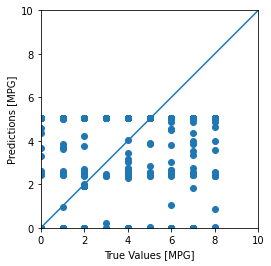

In [9]:
test_predictions = model.predict(data['X_test'])

print(f"x: {test_predictions.size} y: {data['y_test'].size}")

#labels = get_labels(test_predictions)

a = plt.axes(aspect='equal')
plt.scatter(data['y_test'], test_predictions) #labels)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)





# evaluating the model using the testing set
print(f"Evaluating the model using {len(data['X_test'])} samples...")
loss, accuracy = model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

### Baysian Neural Network for 9 Age Categories

In [ ]:
# construct the model
model = create_bnn_model(dataset_size=len(data["y_train"]))

tf.keras.backend.clear_session()
# use tensorboard to view metrics
# tensorboard = TensorBoard(log_dir="voice_nn_logs")
# define early stopping to stop training after 5 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=20, restore_best_weights=True, monitor="loss")

batch_size = 8
epochs = 100
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs/voice_bnn_logs_4", histogram_freq=1)
# train the model using the training set and validating using validation set
model.fit(
    data["X_train"], 
    data["y_train"],
    epochs=epochs, 
    use_multiprocessing=True,
    batch_size=batch_size, 
    validation_data=(data["X_valid"], data["y_valid"]),
    callbacks=[tensorboard_callback, early_stopping], 
    validation_freq=5)

### Traditional Neural Network for 3 Age Groups

In [71]:
# load the dataset
X, y = load_data_mf()
# split the data into training, validation and testing sets
data = split_data(X, y, test_size=0.1, valid_size=0.1)

71210it [47:37, 24.92it/s]
Loading data:  96%|█████████▋| 68544/71210 [03:29<00:08, 327.70it/s]


In [72]:
np.unique(y)

array([0., 1.])

In [18]:
model = create_model()

tf.keras.backend.clear_session()
# use tensorboard to view metrics
# tensorboard = TensorBoard(log_dir="voice_nn_logs")
# define early stopping to stop training after 5 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=20, restore_best_weights=True)

batch_size = 128
epochs = 100
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs/voice_nn_logs_9", histogram_freq=1)
# train the model using the training set and validating using validation set
model.fit(
    data["X_train"], 
    data["y_train"],
    epochs=epochs, 
    use_multiprocessing=True,
    batch_size=batch_size, 
    validation_data=(data["X_valid"], data["y_valid"]),
    callbacks=[tensorboard_callback, early_stopping], 
    validation_freq=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              31459328  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               5

### Mixed model for 3 Age Groups

In [28]:
model = create_mixed_model(dataset_size=len(data["y_train"]))

tf.keras.backend.clear_session()
# use tensorboard to view metrics
# tensorboard = TensorBoard(log_dir="voice_nn_logs")
# define early stopping to stop training after 5 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=20, restore_best_weights=True)

batch_size = 128
epochs = 100
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs/voice_nn_logs_10", histogram_freq=1)
# train the model using the training set and validating using validation set
model.fit(
    data["X_train"], 
    data["y_train"],
    epochs=epochs, 
    use_multiprocessing=True,
    batch_size=batch_size, 
    validation_data=(data["X_valid"], data["y_valid"]),
    callbacks=[tensorboard_callback, early_stopping], 
    validation_freq=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 2048)              31459328  
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)              

## Gender NN

In [13]:
# load the dataset
X, y = load_data_mf()
# split the data into training, validation and testing sets
data = split_data(X, y, test_size=0.1, valid_size=0.1)

In [14]:
np.unique(y)

array([0., 1.])

In [15]:
model = create_bnn_model_gender(dataset_size=len(data["y_train"]))

tf.keras.backend.clear_session()
# use tensorboard to view metrics
# tensorboard = TensorBoard(log_dir="voice_nn_logs")
# define early stopping to stop training after 5 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=10, restore_best_weights=True)

batch_size = 8
epochs = 100
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs/voice_gender_nn_logs_13", histogram_freq=1)
# train the model using the training set and validating using validation set
model.fit(
    data["X_train"], 
    data["y_train"],
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(data["X_valid"], data["y_valid"]),
    callbacks=[tensorboard_callback, early_stopping], 
    validation_freq=1)

C:\Users\nnuss_fkzxayn\miniconda3\envs\ppl-new\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_tfp_1 (DenseFlipout)   (None, 512)               15729152  
_________________________________________________________________
dense_tfp_2 (DenseFlipout)   (None, 256)               262400    
_________________________________________________________________
dense_tfp_3 (DenseFlipout)   (None, 256)               131328    
_________________________________________________________________
dense_tfp_4 (DenseFlipout)   (None, 128)               65664     
_________________________________________________________________
dense_tfp_5

x: 7121 y: 7121
Evaluating the model using 7121 samples...
Loss: 0.9682
Accuracy: 84.69%


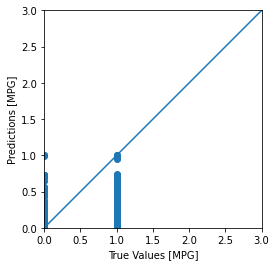

In [16]:
test_predictions = model.predict(data['X_test'])

print(f"x: {test_predictions.size} y: {data['y_test'].size}")

a = plt.axes(aspect='equal')
plt.scatter(data['y_test'], test_predictions) #labels)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 3]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)





# evaluating the model using the testing set
print(f"Evaluating the model using {len(data['X_test'])} samples...")
loss, accuracy = model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

In [17]:
# save the model to a file
model.save("voice_results/voice_bnn_gender_model_1")

INFO:tensorflow:Assets written to: voice_results/voice_bnn_gender_model_1\assets


x: 7121 y: 7121
Evaluating the model using 7121 samples...
Loss: 2.7664
Accuracy: 55.91%


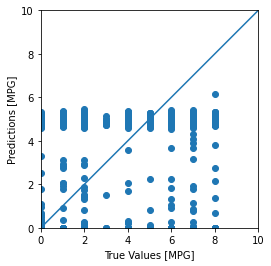

In [36]:
test_predictions = model.predict(data['X_test'])

print(f"x: {test_predictions.size} y: {data['y_test'].size}")

a = plt.axes(aspect='equal')
plt.scatter(data['y_test'], test_predictions) #labels)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)





# evaluating the model using the testing set
print(f"Evaluating the model using {len(data['X_test'])} samples...")
loss, accuracy = model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")